# Actor Crtic for Continous Action Environment

In this notebook, we will implement Actor Critic algorithm for Mountain car continous Environment.

## Mountain Car

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. We will experiment with the continouse version in this one.


![Mountain Car](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The observation is a ndarray with shape (2,) where the elements correspond to the position of the car along the x-axis and the velocity of the car.

The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1] and multiplied by a power of 0.0015.

A negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

You can read more the MountainCar Continous environment [here](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

## Continous Action Spaces

It's conceptually the same as for discrete action spaces. In discrete action spaces you have a discrete distribution like the categorical distribution and you calculate the log pi probabilities using its mass function. In continuous action spaces you use a continuous distribution like the Gaussian distribution and calculate the log pi “probabilities” using its density function. Everything else is the same.

So instead of having network that outputs the parameters for a categorical distribution, you have a network that outputs parameters for (usually) a Gaussian distribution (i.e. the mean and standard deviation)

But, usually we just output the mean using a neural network, and have a separate set of learnable parameters for std (in log space) for each action. For example, if we 3 continous actions then we will have a neural network which will output the means for these actions and then separate 3 parameters which will represent the log std of these actions. We still learn these log std but they are not dependent on state. We just have a log std for each action.

Other approaches for std include:
- Having a std as output of neural network just as the mean.
- Initializing some std for all actions at start and then steadily decrease if using a std_decay hyperparameter as the training progresses.


You can use any appraoch you like.



## Reward Function

As mentioned above, s negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

However, you can change this reward function and write a custom one if you like and think it will make the agent learn better.

## Actor Critic Methods

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function.

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this tutorial, both the *Actor* and *Critic* will be represented using one neural network with two outputs.




### 3. The Actor-Critic loss

Since you're using a hybrid Actor-Critic model, the chosen loss function is a combination of Actor and Critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### The Actor loss

The Actor loss is based on [policy gradients with the Critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (Actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (Critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### The Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [Advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the Critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the Critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the Critic, it may turn out that there's no Advantage ($G - V = 0$), and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

Due to the usage of this advantage function, this algorithm is also **Advantage Actor Critic (A2C)**.
<br>

#### The Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


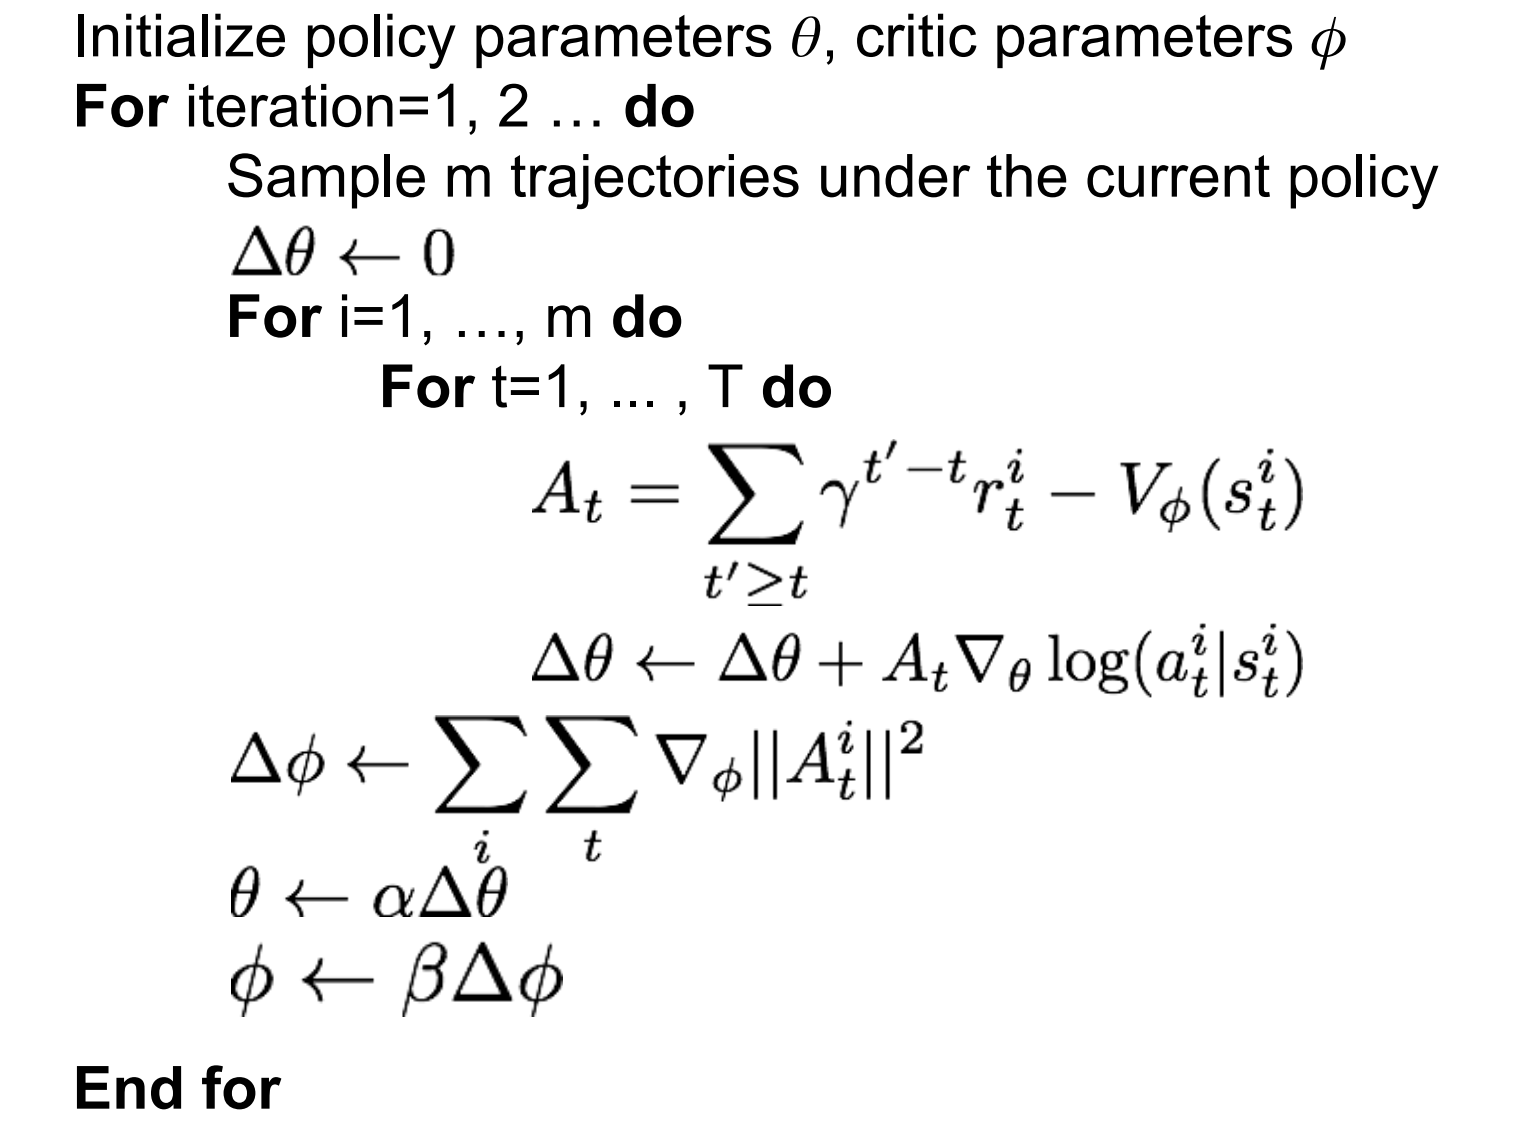

[Image Source](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture14.pdf)

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create the environment
env = gym.make('MountainCarContinuous-v0')

### Network

### Hyperparameters

### Training

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action = ????
        next_state, reward, done, info = env.step([action])
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [ ]:
show_video_of_model("MountainCarCont")

In [ ]:
show_video("MountainCarCont")